In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import gzip
import io
import os

# Define a pasta de saída para o novo padrão: main_files
output_folder = 'main_files'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    print(f"Pasta '{output_folder}' criada.")
else:
    print(f"Pasta '{output_folder}' já existe.")

print("Bibliotecas importadas e ambiente configurado.")

Pasta 'main_files' criada.
Bibliotecas importadas e ambiente configurado.


In [2]:
def load_epinions_data():
    url = "https://snap.stanford.edu/data/soc-Epinions1.txt.gz"
    print(f"Iniciando download do dataset: {url}")
    
    response = requests.get(url)
    content = gzip.decompress(response.content)
    
    print("Download concluído. Processando o grafo...")
    df = pd.read_csv(io.BytesIO(content), sep='\t', comment='#', names=['source', 'target'])
    
    # Cria o Grafo Direcionado (DiGraph)
    G = nx.from_pandas_edgelist(df, 'source', 'target', create_using=nx.DiGraph())
    
    return G

# Carrega o grafo na variável 'G'
G = load_epinions_data()

print("-" * 30)
print(f"Grafo carregado com sucesso! Nós: {G.number_of_nodes()}")

Iniciando download do dataset: https://snap.stanford.edu/data/soc-Epinions1.txt.gz
Download concluído. Processando o grafo...
------------------------------
Grafo carregado com sucesso! Nós: 75879


In [3]:
def manual_pagerank(G, d=0.85, tol=1.0e-4, max_iter=100):
    """
    Implementação do PageRank baseada na fórmula iterativa.
    PR(pi) = (1-d)/N + d * sum(PR(pj)/L(pj))
    """
    N = G.number_of_nodes()
    pr = {node: 1.0/N for node in G.nodes()}
    out_degree = dict(G.out_degree())
    
    print(f"Iniciando cálculo do PageRank (d={d})...")
    
    for i in range(max_iter):
        new_pr = {}
        change = 0
        base_value = (1 - d) / N
        
        for node in G.nodes():
            incoming_sum = 0
            
            # Soma PR(pj)/L(pj) para todos os predecessores
            for predecessor in G.predecessors(node):
                degree = out_degree[predecessor]
                if degree > 0:
                    incoming_sum += pr[predecessor] / degree
            
            val = base_value + (d * incoming_sum)
            new_pr[node] = val
            
            change += abs(new_pr[node] - pr[node])
        
        pr = new_pr
        
        if change < tol:
            print(f"Convergência alcançada na iteração {i+1}!")
            break
        elif (i+1) % 10 == 0:
             print(f"Iteração {i+1}: Erro atual = {change:.6f}")
            
    return pr

In [4]:
# Executar o algoritmo manual
pr_manual = manual_pagerank(G, d=0.85)

# Executar o NetworkX para referência
pr_nx = nx.pagerank(G, alpha=0.85)

# Função auxiliar para ordenar e pegar os top K
def get_top_k(pr_dict, k=10):
    return sorted(pr_dict.items(), key=lambda x: x[1], reverse=True)[:k]

top_manual = get_top_k(pr_manual)
top_nx = get_top_k(pr_nx)

print("\n--- Top 10 Influenciadores (d=0.85) ---")
print(f"{'Pos':<5} | {'Nó Manual':<10} | {'Val Manual':<12} || {'Nó NX':<12}")
print("-" * 65)
for i in range(10):
    m_node, m_val = top_manual[i]
    n_node, n_val = top_nx[i]
    print(f"{i+1:<5} | {m_node:<10} | {m_val:.6f}     || {n_node:<12}")

# Validação estatística
vals_m = [pr_manual[n] for n in G.nodes()]
vals_n = [pr_nx[n] for n in G.nodes()]
corr = np.corrcoef(vals_m, vals_n)[0,1]
print(f"\nCorrelação entre as implementações: {corr:.4f}")

Iniciando cálculo do PageRank (d=0.85)...
Iteração 10: Erro atual = 0.004246
Iteração 20: Erro atual = 0.000594
Iteração 30: Erro atual = 0.000103
Convergência alcançada na iteração 31!

--- Top 10 Influenciadores (d=0.85) ---
Pos   | Nó Manual  | Val Manual   || Nó NX       
-----------------------------------------------------------------
1     | 18         | 0.003252     || 18          
2     | 737        | 0.002259     || 737         
3     | 118        | 0.001522     || 1719        
4     | 1719       | 0.001490     || 790         
5     | 136        | 0.001425     || 118         
6     | 790        | 0.001412     || 136         
7     | 143        | 0.001403     || 143         
8     | 40         | 0.001309     || 40          
9     | 1619       | 0.001102     || 1619        
10    | 725        | 0.001073     || 4415        

Correlação entre as implementações: 0.9942


Iniciando análise de variação do fator 'd'...

Gráfico salvo em 'main_files/variacao_damping.png'


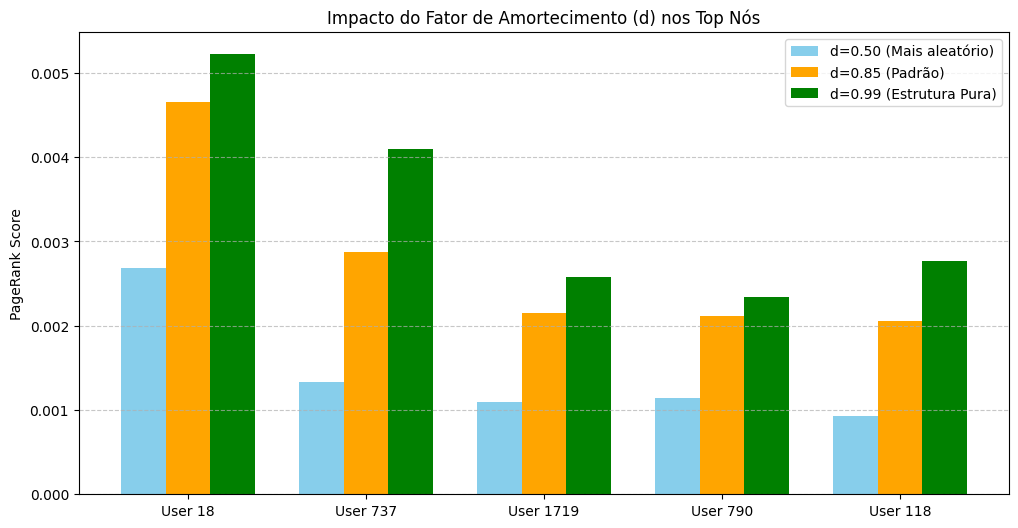

In [5]:
print("Iniciando análise de variação do fator 'd'...")

factors = [0.50, 0.85, 0.99]
results = {}

for d in factors:
    results[d] = nx.pagerank(G, alpha=d)

# Plotar comparação dos Top 5 nós para diferentes 'd'
top_nodes_base = [n for n, v in get_top_k(results[0.85], 5)]
vals_d50 = [results[0.50][n] for n in top_nodes_base]
vals_d85 = [results[0.85][n] for n in top_nodes_base]
vals_d99 = [results[0.99][n] for n in top_nodes_base]

x = np.arange(len(top_nodes_base))
width = 0.25

fig, ax = plt.subplots(figsize=(12, 6))
plt.bar(x - width, vals_d50, width, label='d=0.50 (Mais aleatório)', color='skyblue')
plt.bar(x, vals_d85, width, label='d=0.85 (Padrão)', color='orange')
plt.bar(x + width, vals_d99, width, label='d=0.99 (Estrutura Pura)', color='green')

plt.ylabel('PageRank Score')
plt.title('Impacto do Fator de Amortecimento (d) nos Top Nós')
plt.xticks(x, [f"User {n}" for n in top_nodes_base])
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Salva o gráfico na nova pasta padronizada
plt.savefig('main_files/variacao_damping.png')
print("\nGráfico salvo em 'main_files/variacao_damping.png'")
plt.show()